Epoch 1/10 | Train Loss: 0.5640, Train Acc: 78.28% | Val Loss: 0.5390, Val Acc: 82.52%
Epoch 2/10 | Train Loss: 0.2278, Train Acc: 98.00% | Val Loss: 0.3305, Val Acc: 85.44%
Epoch 3/10 | Train Loss: 0.0860, Train Acc: 99.20% | Val Loss: 0.3804, Val Acc: 73.79%
Epoch 4/10 | Train Loss: 0.0458, Train Acc: 99.52% | Val Loss: 0.3484, Val Acc: 75.73%
Epoch 5/10 | Train Loss: 0.0323, Train Acc: 99.54% | Val Loss: 0.3347, Val Acc: 75.73%
Epoch 6/10 | Train Loss: 0.0261, Train Acc: 99.54% | Val Loss: 0.3948, Val Acc: 74.76%
Epoch 7/10 | Train Loss: 0.0216, Train Acc: 99.62% | Val Loss: 0.3712, Val Acc: 76.70%
Epoch 8/10 | Train Loss: 0.0186, Train Acc: 99.73% | Val Loss: 0.2561, Val Acc: 87.38%
Epoch 9/10 | Train Loss: 0.0200, Train Acc: 99.62% | Val Loss: 0.2282, Val Acc: 89.32%
Epoch 10/10 | Train Loss: 0.0158, Train Acc: 99.70% | Val Loss: 0.2133, Val Acc: 90.29%

✅ Training complete. Model saved to: resnet50_crack_detector.pth

📊 Final Training and Validation Metrics:
Epoch 1: Train Loss: 

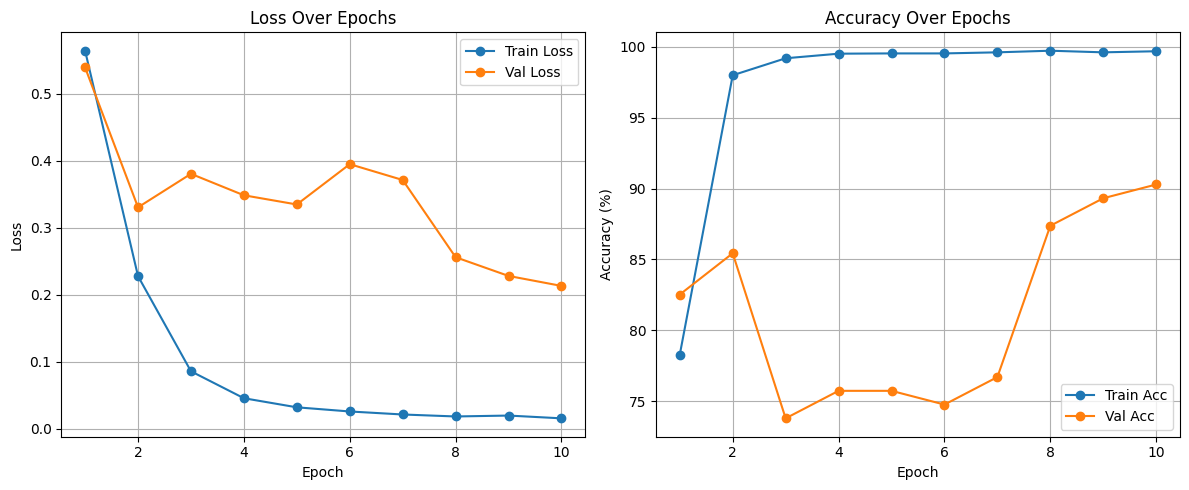

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
train_dir = '/content/drive/MyDrive/5000 IMAGES'
val_dir = '/content/drive/MyDrive/VALIDATION'

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training function
def train_model(model, train_loader, val_loader, epochs=10, save_path='resnet50_crack_detector.pth'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save final model
    torch.save(model.state_dict(), save_path)
    print(f"\n✅ Training complete. Model saved to: {save_path}")

    # Summary
    print("\n📊 Final Training and Validation Metrics:")
    for i in range(epochs):
        print(f"Epoch {i+1}: "
              f"Train Loss: {train_losses[i]:.4f}, Train Acc: {train_accuracies[i]:.2f}%, "
              f"Val Loss: {val_losses[i]:.4f}, Val Acc: {val_accuracies[i]:.2f}%")

    # Plotting
    plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

# Plot function
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs_range = range(1, len(train_losses)+1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Val Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Acc', marker='o')
    plt.plot(epochs_range, val_accuracies, label='Val Acc', marker='o')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Train ResNet50
def train_resnet50():
    weights = ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 2)
    )

    train_model(model, train_loader, val_loader)

# Entry
if __name__ == "__main__":
    train_resnet50()



📝 Classification Report:
                precision    recall  f1-score   support

Cracked images       0.94      0.88      0.91        58
     UNCRACKED       0.86      0.93      0.89        45

      accuracy                           0.90       103
     macro avg       0.90      0.91      0.90       103
  weighted avg       0.91      0.90      0.90       103



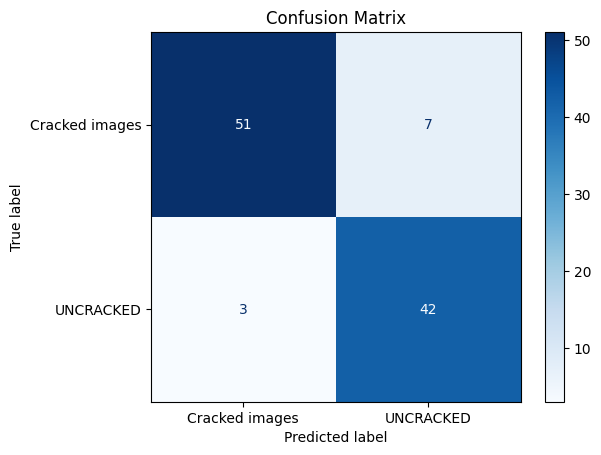

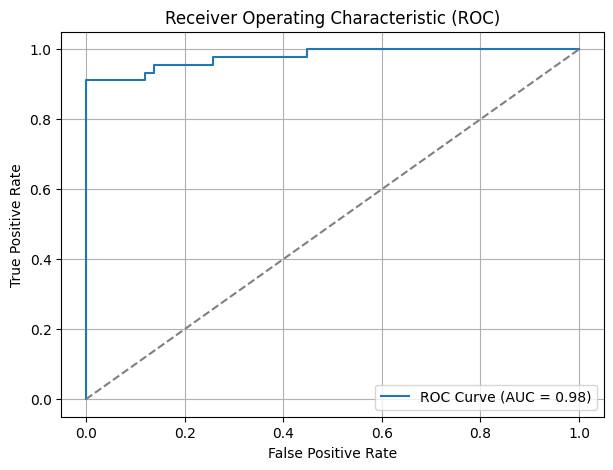

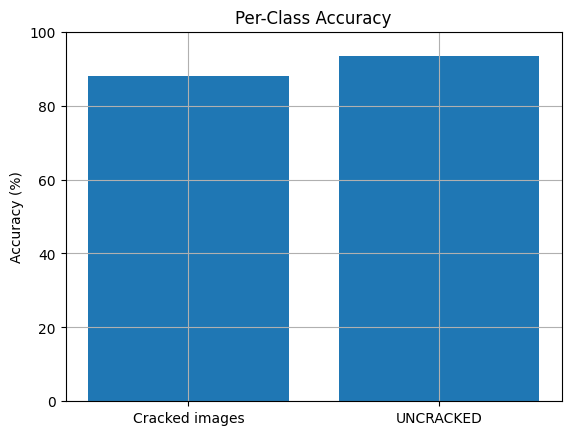


❌ Misclassified Samples with Grad-CAM:
Image 2: True=Cracked images, Predicted=UNCRACKED, Confidence=0.59


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


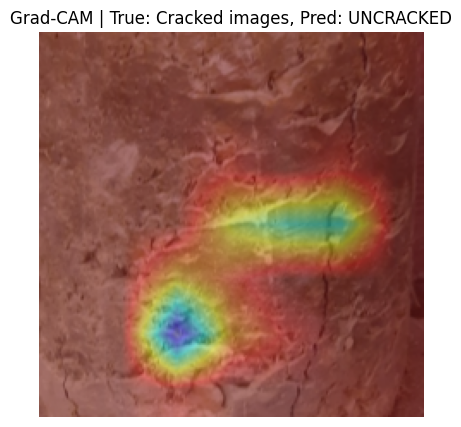

Image 3: True=Cracked images, Predicted=UNCRACKED, Confidence=0.90


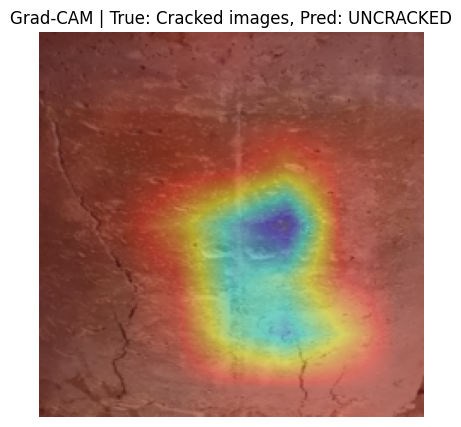

Image 17: True=Cracked images, Predicted=UNCRACKED, Confidence=0.70


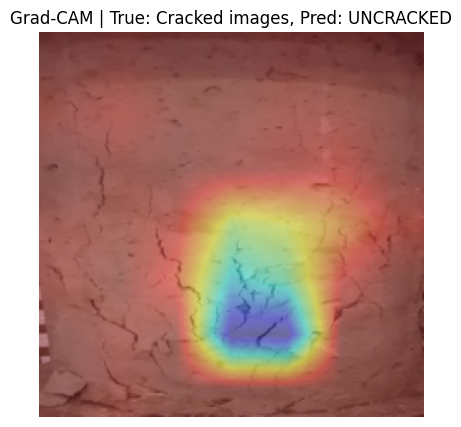

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Set paths and device
model_path = 'resnet50_crack_detector.pth'
val_dir = '/content/drive/MyDrive/VALIDATION'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load validation dataset
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
class_names = val_dataset.classes

# Load trained model
def load_model(path):
    model = models.resnet50(weights=None)
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 2)
    )
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        loss = output[:, class_idx].sum()
        loss.backward()
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()
        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()

# Grad-CAM visualization
def show_gradcam(model, image_tensor, true_label, pred_label, idx, class_names):
    cam_extractor = GradCAM(model, model.layer4[-1])
    cam = cam_extractor.generate(image_tensor.unsqueeze(0).to(device), pred_label)
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * 0.5 + 0.5) * 255
    img = np.uint8(img)
    cam_resized = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM | True: {class_names[true_label]}, Pred: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()

# Model evaluation
def evaluate_model(model, dataloader):
    y_true, y_pred, y_scores = [], [], []
    images_all = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)

            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            images_all.extend(images.cpu())

    # Classification Report
    print("\n📝 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Per-Class Accuracy
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    for i in range(len(y_true)):
        label = y_true[i]
        class_total[label] += 1
        if y_pred[i] == label:
            class_correct[label] += 1

    acc_per_class = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]
    plt.bar(class_names, acc_per_class)
    plt.ylabel("Accuracy (%)")
    plt.title("Per-Class Accuracy")
    plt.ylim([0, 100])
    plt.grid(True)
    plt.show()

    # Grad-CAM on Misclassified Samples
    print("\n❌ Misclassified Samples with Grad-CAM:")
    misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    if misclassified_indices:
        for i in misclassified_indices[:3]:
            print(f"Image {i}: True={class_names[y_true[i]]}, Predicted={class_names[y_pred[i]]}, Confidence={y_scores[i]:.2f}")
            show_gradcam(model, images_all[i], y_true[i], y_pred[i], i, class_names)
    else:
        print("None. Great job!")

# Run evaluation
model = load_model(model_path)
evaluate_model(model, val_loader)